In [137]:
# !pip install yahoo-fin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yahoo_fin import stock_info as si
import yfinance as yf
import datetime
import logging
import time
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
from functools import reduce
import matplotlib.dates as mdates

In [6]:
import warnings
warnings.filterwarnings('ignore')

https://theautomatic.net/yahoo_fin-documentation/

# Preprocessing

### Tickers & Price

In [2]:
# get list of S&P 500 tickers
sp = si.tickers_sp500()
 
# pull data for each S&P stock
price_data = {ticker : si.get_data(ticker) for ticker in sp}

len(sp)

503

In [7]:
combined = reduce(lambda x,y: x.append(y), price_data.values())
combined.head()

,open,high,low,close,adjclose,volume,ticker
1999-11-18,32.546494,35.765381,28.612303,31.473534,26.845926,62546380,A
1999-11-19,30.713518,30.758226,28.478184,28.880545,24.634184,15234146,A
1999-11-22,29.551144,31.473534,28.657009,31.473534,26.845926,6577870,A
1999-11-23,30.400572,31.205294,28.612303,28.612303,24.405390,5975611,A
1999-11-24,28.701717,29.998213,28.612303,29.372318,25.053656,4843231,A


In [8]:
combined['date'] = combined.index
combined.head()

,open,high,low,close,adjclose,volume,ticker,date
1999-11-18,32.546494,35.765381,28.612303,31.473534,26.845926,62546380,A,1999-11-18
1999-11-19,30.713518,30.758226,28.478184,28.880545,24.634184,15234146,A,1999-11-19
1999-11-22,29.551144,31.473534,28.657009,31.473534,26.845926,6577870,A,1999-11-22
1999-11-23,30.400572,31.205294,28.612303,28.612303,24.405390,5975611,A,1999-11-23
1999-11-24,28.701717,29.998213,28.612303,29.372318,25.053656,4843231,A,1999-11-24


### Sector & Industry

In [53]:
cie_info = {}

for ticker in sp:
    yf_symbol = yf.Ticker(ticker)
    cie_info[ticker] = yf_symbol.info

In [74]:
combined_info = pd.DataFrame.from_dict(cie_info, orient='index')
combined_info = combined_info[["industry","sector"]]
combined_info.reset_index(inplace=True)
combined_info.rename(columns={'index': 'ticker'}, inplace=True)
combined_info.head()

,ticker,industry,sector
0,A,Diagnostics & Research,Healthcare
1,AAL,Airlines,Industrials
2,AAP,Specialty Retail,Consumer Cyclical
3,AAPL,Consumer Electronics,Technology
4,ABBV,Drug Manufacturers—General,Healthcare


In [76]:
all=combined.merge(combined_info, on='ticker')
all.head()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector
0,32.546494,35.765381,28.612303,31.473534,26.845926,62546380,A,1999-11-18,Diagnostics & Research,Healthcare
1,30.713518,30.758226,28.478184,28.880545,24.634184,15234146,A,1999-11-19,Diagnostics & Research,Healthcare
2,29.551144,31.473534,28.657009,31.473534,26.845926,6577870,A,1999-11-22,Diagnostics & Research,Healthcare
3,30.400572,31.205294,28.612303,28.612303,24.405390,5975611,A,1999-11-23,Diagnostics & Research,Healthcare
4,28.701717,29.998213,28.612303,29.372318,25.053656,4843231,A,1999-11-24,Diagnostics & Research,Healthcare


In [77]:
all.isnull().values.any()

True

In [78]:
all.dropna(inplace=True)
print(all.isnull().values.any())

False


### Lags

In [114]:
for lag in range(0,5):
    all[f'lag_{lag}'] = all['close'].shift(lag)

all=all[all['lag_4'].notnull()]

all['next'] = all['close'].shift(-1)
all.head()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,lag_0,lag_1,lag_2,lag_3,lag_4,next
8,30.177038,31.071173,29.953505,30.713518,26.197653,2957329,A,1999-12-01,Diagnostics & Research,Healthcare,30.713518,30.177038,30.132332,29.461731,29.372318,31.562946
9,31.294706,32.188843,30.892345,31.562946,26.922188,3069868,A,1999-12-02,Diagnostics & Research,Healthcare,31.562946,30.713518,30.177038,30.132332,29.461731,31.831186
10,32.144135,32.680614,31.697067,31.831186,27.150988,3041629,A,1999-12-03,Diagnostics & Research,Healthcare,31.831186,31.562946,30.713518,30.177038,30.132332,32.725323
11,32.367668,33.217094,32.322960,32.725323,27.913660,2250780,A,1999-12-06,Diagnostics & Research,Healthcare,32.725323,31.831186,31.562946,30.713518,30.177038,32.367668
12,32.725323,32.904148,31.697067,32.367668,27.608589,2215970,A,1999-12-07,Diagnostics & Research,Healthcare,32.367668,32.725323,31.831186,31.562946,30.713518,32.322960


In [115]:
def tagger(row):
    if row['next']<row['lag_0']:
        return 'Sell'
    else:
        return 'Buy'
all['out'] = all.apply(tagger ,axis=1)
all.head()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,lag_0,lag_1,lag_2,lag_3,lag_4,next,out
8,30.177038,31.071173,29.953505,30.713518,26.197653,2957329,A,1999-12-01,Diagnostics & Research,Healthcare,30.713518,30.177038,30.132332,29.461731,29.372318,31.562946,Buy
9,31.294706,32.188843,30.892345,31.562946,26.922188,3069868,A,1999-12-02,Diagnostics & Research,Healthcare,31.562946,30.713518,30.177038,30.132332,29.461731,31.831186,Buy
10,32.144135,32.680614,31.697067,31.831186,27.150988,3041629,A,1999-12-03,Diagnostics & Research,Healthcare,31.831186,31.562946,30.713518,30.177038,30.132332,32.725323,Buy
11,32.367668,33.217094,32.322960,32.725323,27.913660,2250780,A,1999-12-06,Diagnostics & Research,Healthcare,32.725323,31.831186,31.562946,30.713518,30.177038,32.367668,Sell
12,32.725323,32.904148,31.697067,32.367668,27.608589,2215970,A,1999-12-07,Diagnostics & Research,Healthcare,32.367668,32.725323,31.831186,31.562946,30.713518,32.322960,Sell


In [116]:
stock_day = all.loc[all['date'].isin(['2022-09-30'])]
stock_day.tail()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,lag_0,lag_1,lag_2,lag_3,lag_4,next,out
4118726,107.290001,108.599998,106.339996,106.339996,104.880440,1797400,YUM,2022-09-30,Restaurants,Consumer Cyclical,106.339996,107.209999,108.120003,107.769997,109.160004,109.110001,Buy
4124236,107.459999,108.339996,104.519997,104.550003,104.153336,1138700,ZBH,2022-09-30,Medical Devices,Healthcare,104.550003,107.120003,107.529999,104.820000,105.150002,107.320000,Buy
4132257,264.839996,271.959991,261.630005,262.010010,262.010010,378500,ZBRA,2022-09-30,Communication Equipment,Technology,262.010010,265.519989,271.350006,264.950012,265.859985,272.089996,Buy
4143164,51.759998,52.150002,50.790001,50.860001,49.192753,1611500,ZION,2022-09-30,Banks—Regional,Financial Services,50.860001,51.779999,53.270000,52.759998,53.529999,52.209999,Buy
4145777,150.419998,152.029999,148.039993,148.289993,147.312302,2437200,ZTS,2022-09-30,Drug Manufacturers—Specialty & Generic,Healthcare,148.289993,150.949997,152.259995,149.399994,148.600006,151.350006,Buy


# Ticker and High Level

In [216]:
mask = (all['date'] > '2022-01-01') & (all['date'] <= '2022-06-30') & (all['ticker'] == 'AAPL')
aapl = all.loc[mask]
aapl.head()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,lag_0,lag_1,lag_2,lag_3,lag_4,next,out
26172,177.830002,182.880005,177.710007,182.009995,180.434296,104487900,AAPL,2022-01-03,Consumer Electronics,Technology,182.009995,177.570007,178.199997,179.380005,179.289993,179.699997,Sell
26173,182.630005,182.940002,179.119995,179.699997,178.144287,99310400,AAPL,2022-01-04,Consumer Electronics,Technology,179.699997,182.009995,177.570007,178.199997,179.380005,174.919998,Sell
26174,179.610001,180.169998,174.639999,174.919998,173.405670,94537600,AAPL,2022-01-05,Consumer Electronics,Technology,174.919998,179.699997,182.009995,177.570007,178.199997,172.000000,Sell
26175,172.699997,175.300003,171.639999,172.000000,170.510956,96904000,AAPL,2022-01-06,Consumer Electronics,Technology,172.000000,174.919998,179.699997,182.009995,177.570007,172.169998,Buy
26176,172.889999,174.139999,171.029999,172.169998,170.679504,86709100,AAPL,2022-01-07,Consumer Electronics,Technology,172.169998,172.000000,174.919998,179.699997,182.009995,172.190002,Buy


In [168]:
print("Buy = " + str(aapl['out'].value_counts()['Buy']))
print("Sell = " + str(aapl['out'].value_counts()['Sell']))

Buy = 59
Sell = 65


([<matplotlib.patches.Wedge at 0x2b0b88b80>,
 [Text(-0.08352634614421449, 1.0968242108468418, 'BUY'),
  Text(0.08352624345211987, -1.0968242186671378, 'SELL')],
 [Text(-0.045559825169571536, 0.5982677513710045, '52%'),
  Text(0.04555976915570174, -0.5982677556366206, '48%')])

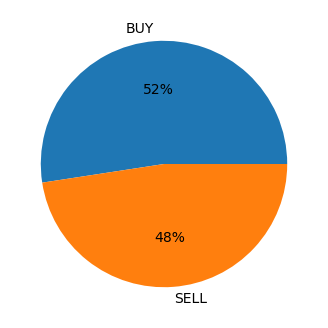

In [196]:
plt.rc('figure', figsize=(4, 4))
plt.pie(aapl['out'].value_counts(),labels=['BUY','SELL'],autopct='%.0f%%')

In [160]:
aapl['diff_close'] = aapl.loc[:,'close'].diff()

<AxesSubplot:>

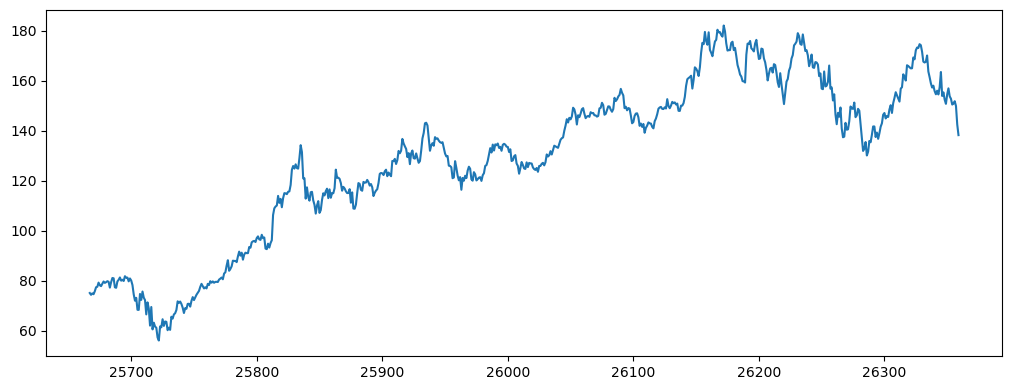

In [162]:
aapl['close'].plot(figsize=(12.33,4.5))

<AxesSubplot:>

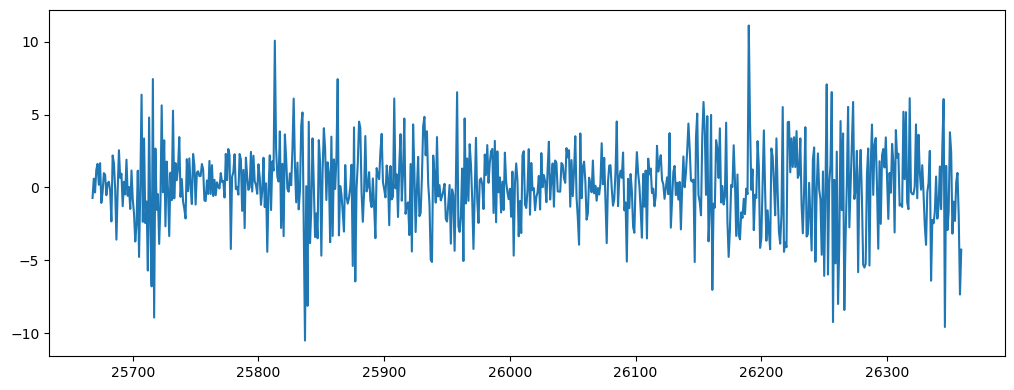

In [136]:
aapl['diff_close'].plot(figsize=(12.33,4.5))

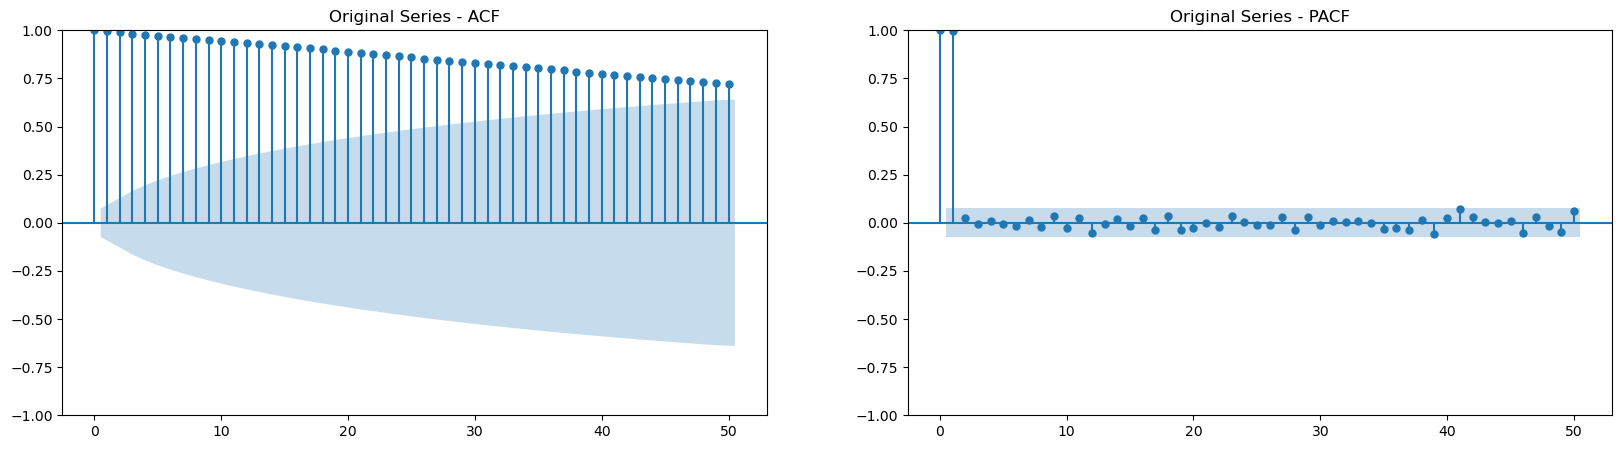

In [139]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(aapl['close'], lags=50, title='Original Series - ACF', ax=ax[0])
plot_pacf(aapl['close'], lags=50, title='Original Series - PACF', ax=ax[1])
plt.show()

# Technical Indicators

### iShare MSCI Australia (EWA) vs SP500
(NYSE, price avalable more late in US but is similar of ^700712-AUD-GRTR in AUD currency)

In [80]:
def tagger(row):
    if row['next']<row['close']:
        return 'Sell'
    else:
        return 'Buy'

In [81]:
ewa = si.get_data('EWA')
ewa['next'] = ewa['close'].shift(-1)
ewa['out'] = ewa.apply(tagger ,axis=1)
ewa = ewa.rename(columns={'out': 'EWA'})
ewa = ewa[['EWA','close']]
ewa.tail()

,EWA,close
2023-06-14,Buy,22.809999
2023-06-15,Buy,23.230000
2023-06-16,Sell,23.330000
2023-06-20,Sell,23.290001
2023-06-21,Buy,23.229601


In [82]:
sp500 = si.get_data('^GSPC')
sp500['next'] = sp500['close'].shift(-1)
sp500['out'] = sp500.apply(tagger ,axis=1)
sp500 = sp500.rename(columns={'out': 'SP500'})
sp500 = sp500[['SP500','close']]
sp500.tail()

,SP500,close
2023-06-14,Buy,4372.589844
2023-06-15,Sell,4425.839844
2023-06-16,Sell,4409.589844
2023-06-20,Sell,4388.709961
2023-06-21,Buy,4374.990234


In [85]:
EWA_SP500 = pd.merge(ewa, sp500, left_index=True, right_index=True)
def check1(row):
    if row['EWA'] == row['SP500']:
        return 1
    else:
        return 0

EWA_SP500['check'] = EWA_SP500.apply(check1 ,axis=1)
EWA_SP500.tail(5)

,EWA,close_x,SP500,close_y,check
2023-06-14,Buy,22.809999,Buy,4372.589844,1
2023-06-15,Buy,23.230000,Sell,4425.839844,0
2023-06-16,Sell,23.330000,Sell,4409.589844,1
2023-06-20,Sell,23.290001,Sell,4388.709961,1
2023-06-21,Buy,23.229601,Buy,4374.990234,1


<AxesSubplot:>

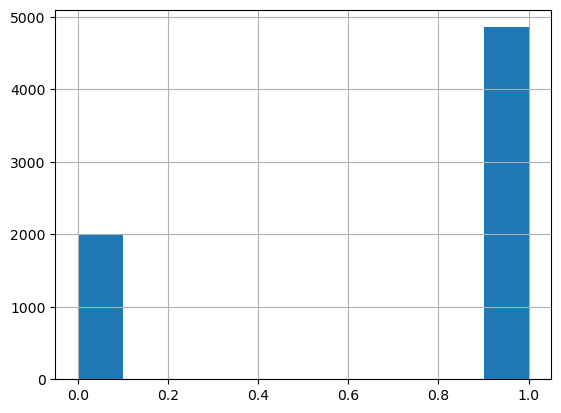

In [86]:
EWA_SP500['check'].hist()

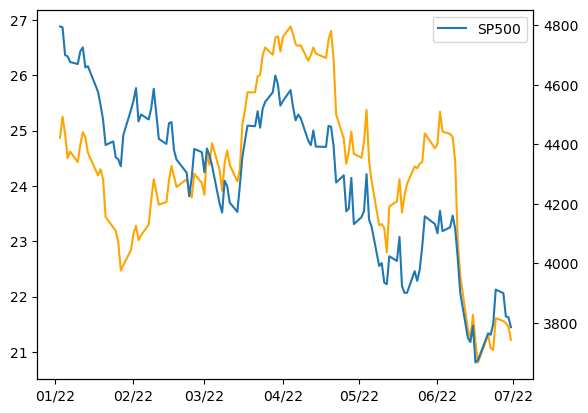

In [95]:
start_date = '2022-01-03'
end_date = '2022-06-30'
my_year_month_fmt = mdates.DateFormatter('%m/%y')

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(ewa.loc[start_date:end_date, :].index, ewa.loc[start_date:end_date, 'close'], label='EWA', color='orange')
ax_right.plot(sp500.loc[start_date:end_date, :].index, sp500.loc[start_date:end_date, 'close'], label = 'SP500')

ax_left.xaxis.set_major_formatter(my_year_month_fmt)
ax_right.legend()

### Fibonacci Retracements:

https://towardsdatascience.com/fibonacci-retracements-in-python-470eb33b6362

https://school.stockcharts.com/doku.php?id=chart_analysis:fibonacci_retracemen

In [215]:
mask = (all['date'] > '2022-01-01') & (all['date'] <= '2022-06-30') & (all['ticker'] == 'AAPL')
aapl = all.loc[mask]
aapl.head()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,lag_0,lag_1,lag_2,lag_3,lag_4,next,out
26172,177.830002,182.880005,177.710007,182.009995,180.434296,104487900,AAPL,2022-01-03,Consumer Electronics,Technology,182.009995,177.570007,178.199997,179.380005,179.289993,179.699997,Sell
26173,182.630005,182.940002,179.119995,179.699997,178.144287,99310400,AAPL,2022-01-04,Consumer Electronics,Technology,179.699997,182.009995,177.570007,178.199997,179.380005,174.919998,Sell
26174,179.610001,180.169998,174.639999,174.919998,173.405670,94537600,AAPL,2022-01-05,Consumer Electronics,Technology,174.919998,179.699997,182.009995,177.570007,178.199997,172.000000,Sell
26175,172.699997,175.300003,171.639999,172.000000,170.510956,96904000,AAPL,2022-01-06,Consumer Electronics,Technology,172.000000,174.919998,179.699997,182.009995,177.570007,172.169998,Buy
26176,172.889999,174.139999,171.029999,172.169998,170.679504,86709100,AAPL,2022-01-07,Consumer Electronics,Technology,172.169998,172.000000,174.919998,179.699997,182.009995,172.190002,Buy


In [97]:
#Calculate the max and min close price
maximum_price = aapl['close'].max()
minimum_price = aapl['close'].min()

difference = maximum_price - minimum_price #Get the difference        
first_level = maximum_price - difference * 0.236   
second_level = maximum_price - difference * 0.382  
third_level = maximum_price - difference * 0.5     
fourth_level = maximum_price - difference * 0.618  

In [98]:
#Print the price at each level
print("Level Percentage\t", "Price ($)")
print("00.0%\t\t", maximum_price)
print("23.6%\t\t", first_level)
print("38.2%\t\t", second_level)
print("50.0%\t\t", third_level)
print("61.8%\t\t", fourth_level)
print("100.0%\t\t", minimum_price)

Level Percentage	 Price ($)
00.0%		 182.00999450683594
23.6%		 169.74979522705078
38.2%		 162.16509567260744
50.0%		 156.03499603271484
61.8%		 149.90489639282225
100.0%		 130.05999755859375


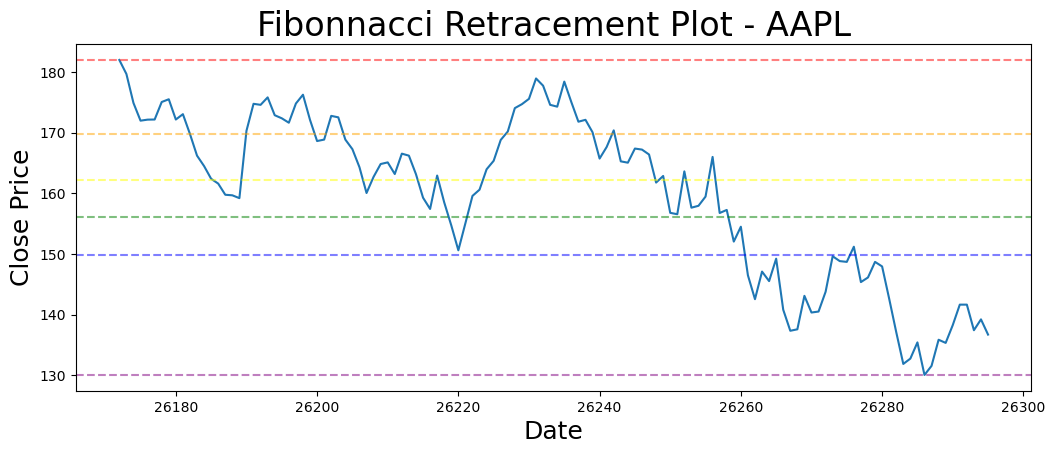

In [99]:
#Plot the Fibonacci levels along with the close price
new_df = aapl
plt.figure(figsize=(12.33,4.5))
plt.title('Fibonnacci Retracement Plot - AAPL',fontsize=24)
plt.plot(new_df.index, new_df['close'])
plt.axhline(maximum_price, linestyle='--', alpha=0.5, color = 'red')
plt.axhline(first_level, linestyle='--', alpha=0.5, color = 'orange')
plt.axhline(second_level, linestyle='--', alpha=0.5, color = 'yellow')
plt.axhline(third_level, linestyle='--', alpha=0.5, color = 'green')
plt.axhline(fourth_level, linestyle='--', alpha=0.5, color = 'blue')
plt.axhline(minimum_price, linestyle='--', alpha=0.5, color = 'purple')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

Fibonacci retracement is based on the assumption that markets retrace by certain predictable percentages, the most common among them being 38.2 per cent, 50 per cent and 61.8 per cent. So, when the market retraces 38 per cent, it will generate either a sell or a buy call depending on the trend. You have to plot Fibonacci retracement from the peak price. The software will give the retracement levels. When the price reaches the 38.2 per cent level and bounces, it means the price of the stock, at which the chart plots the 38.2 per cent retracement, is the support level and you can buy. However, if the price falls below the 38.2 per cent level, you may look at the price at 50 per cent retracement level as your next support. The graph, Fibonacci Retracement, shows how the 38.2 per cent retracement is working well for the Ranbaxy stock.

### Moving Average Trading Strategy:

https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/

In [119]:
mask = (all['date'] > '2022-01-01') & (all['date'] <= '2022-06-30') & (all['ticker'] == 'AAPL')
aapl = all.loc[mask]
aapl = aapl[['close','date']]
aapl = aapl.set_index('date')
aapl.head()

,close
date,
2022-01-03,182.009995
2022-01-04,179.699997
2022-01-05,174.919998
2022-01-06,172.000000
2022-01-07,172.169998


In [120]:
# Calculating the short-window simple moving average
short_rolling = aapl.rolling(window=20).mean()

# Calculating the long-window simple moving average
long_rolling = aapl.rolling(window=100).mean()

# Using Pandas to calculate a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
ema_short = aapl.ewm(span=20, adjust=False).mean()

# Taking the difference between the prices and the EMA timeseries
trading_positions_raw = aapl - ema_short

# Taking the sign of the difference to determine whether the price or the EMA is greater and then multiplying by 1/3
trading_positions = trading_positions_raw.apply(np.sign) * 1/3

# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)

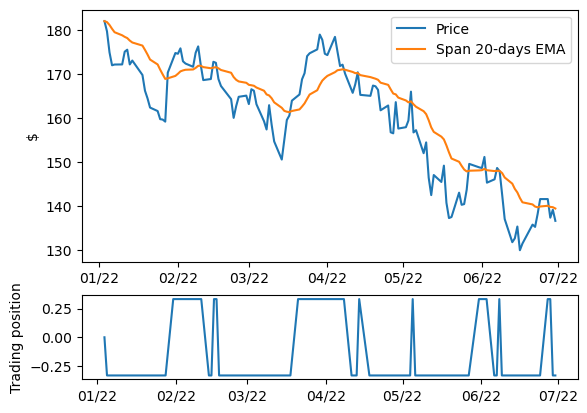

In [121]:
import matplotlib.dates as mdates

start_date = '2022-01-03'
end_date = '2022-06-30'
my_year_month_fmt = mdates.DateFormatter('%m/%y')

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(aapl.loc[start_date:end_date, :].index, aapl.loc[start_date:end_date, 'close'], label='Price')
ax1.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'close'], label = 'Span 20-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date, 'close'], 
        label='Trading position')

ax2.set_ylabel('Trading position')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [122]:
tp = trading_positions_final
tp['date'] = trading_positions_final.index
tp.reset_index(drop=True, inplace=True)
trading_positions_final.head()

,close,date
0,NaN,2022-01-03
1,0.000000,2022-01-04
2,-0.333333,2022-01-05
3,-0.333333,2022-01-06
4,-0.333333,2022-01-07


In [126]:
mask = (all['date'] > '2022-01-01') & (all['date'] <= '2022-06-30') & (all['ticker'] == 'AAPL')
test2 = all.loc[mask]

In [127]:
test=tp.merge(test2, on='date')
test.rename(columns = {'close_x':'trading_positions'}, inplace = True)
test=test[test['trading_positions'].notnull()]
test = test[['date','trading_positions', 'out']]
test = test.iloc[1: , :]
test.head()

,date,trading_positions,out
2,2022-01-05,-0.333333,Sell
3,2022-01-06,-0.333333,Buy
4,2022-01-07,-0.333333,Buy
5,2022-01-10,-0.333333,Buy
6,2022-01-11,-0.333333,Buy


In [130]:
def check(row):
    if row['trading_positions']<0 and row['out']=='Sell':
        return 1
    if row['trading_positions']>0 and row['out']=='Buy':
        return 1    
    else:
        return 0

test['check'] = test.apply(check ,axis=1)
test.tail()

,date,trading_positions,out,check
119,2022-06-24,-0.333333,Buy,0
120,2022-06-27,0.333333,Sell,0
121,2022-06-28,0.333333,Buy,1
122,2022-06-29,-0.333333,Sell,1
123,2022-06-30,-0.333333,Buy,0


array([<AxesSubplot:title={'center':'Buy'}>,
       <AxesSubplot:title={'center':'Sell'}>], dtype=object)

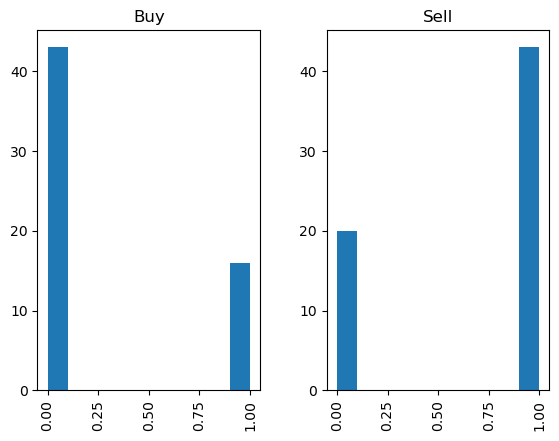

In [131]:
# ouin... sell good \ buy bad
test['check'].hist(by=test['out'])

### Volume & Price

In [132]:
mask = (all['date'] > '2020-01-01') & (all['date'] <= '2022-09-30') & (all['ticker'] == 'AAPL')
aapl = all.loc[mask]
aapl.head()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,lag_0,lag_1,lag_2,lag_3,lag_4,next,out
25667,74.059998,75.150002,73.797501,75.087502,73.347931,135480400,AAPL,2020-01-02,Consumer Electronics,Technology,75.087502,73.412498,72.879997,72.449997,72.477501,74.357498,Sell
25668,74.287498,75.144997,74.125000,74.357498,72.634842,146322800,AAPL,2020-01-03,Consumer Electronics,Technology,74.357498,75.087502,73.412498,72.879997,72.449997,74.949997,Buy
25669,73.447502,74.989998,73.187500,74.949997,73.213615,118387200,AAPL,2020-01-06,Consumer Electronics,Technology,74.949997,74.357498,75.087502,73.412498,72.879997,74.597504,Sell
25670,74.959999,75.224998,74.370003,74.597504,72.869286,108872000,AAPL,2020-01-07,Consumer Electronics,Technology,74.597504,74.949997,74.357498,75.087502,73.412498,75.797501,Buy
25671,74.290001,76.110001,74.290001,75.797501,74.041481,132079200,AAPL,2020-01-08,Consumer Electronics,Technology,75.797501,74.597504,74.949997,74.357498,75.087502,77.407501,Buy


In [133]:
colors = {'red': '#ff207c', 'grey': '#42535b', 'blue': '#207cff', 'orange': '#ffa320', 'green': '#00ec8b'}
config_ticks = {'size': 14, 'color': colors['grey'], 'labelcolor': colors['grey']}
config_title = {'size': 18, 'color': colors['grey'], 'ha': 'left', 'va': 'baseline'}

<BarContainer object of 693 artists>

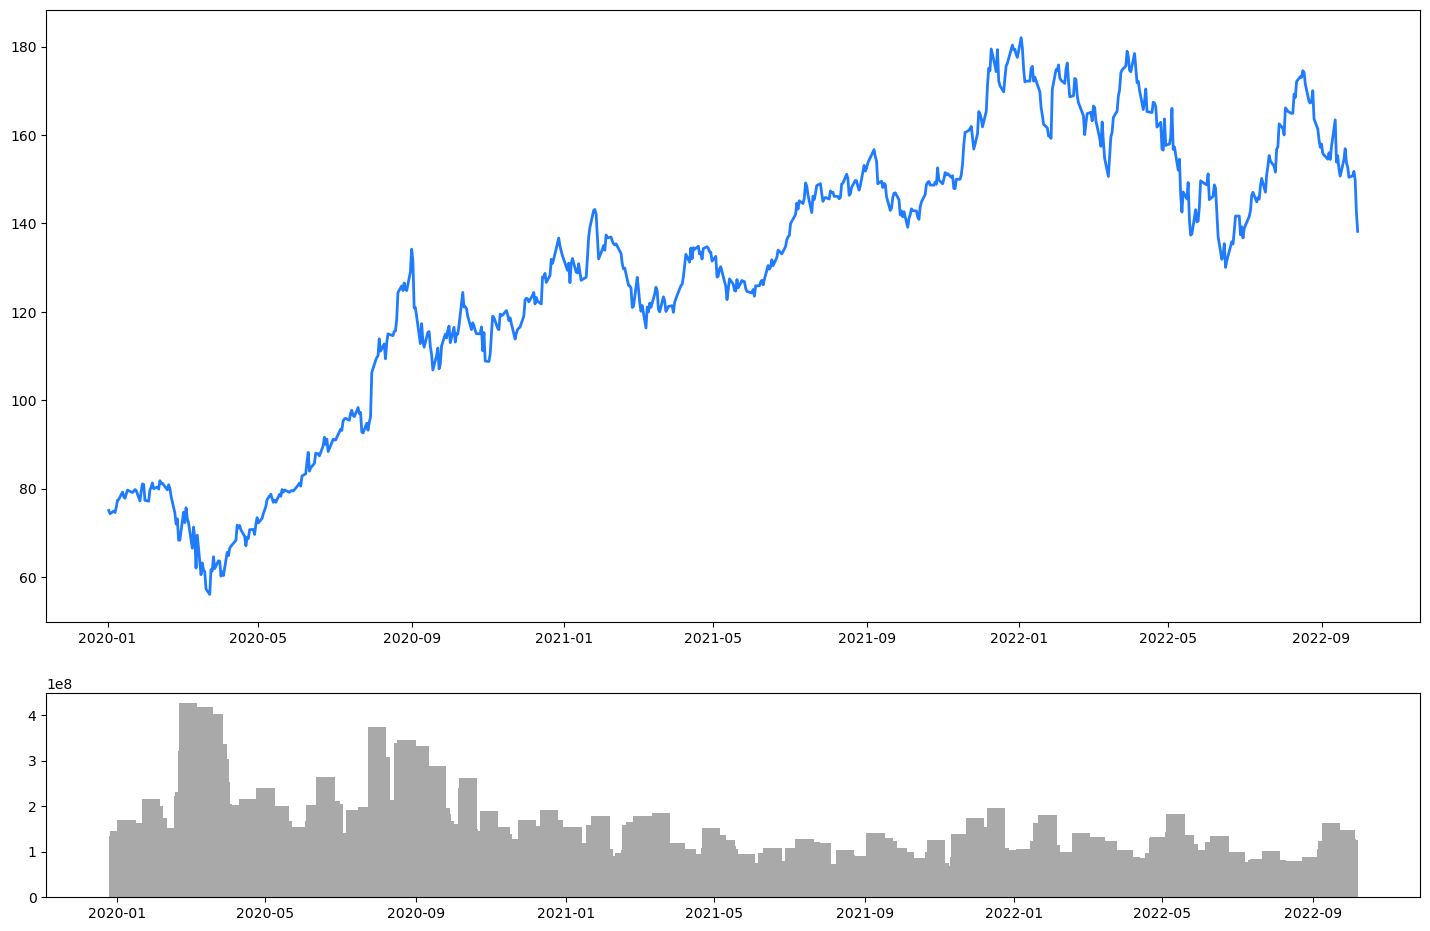

In [134]:
plt.rc('figure', figsize=(15, 10))
    
fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
fig.tight_layout(pad=3)
    
date = aapl['date']
close = aapl['close']
vol = aapl['volume']
    
plot_price = axes[0]
plot_price.plot(date, close, color=colors['blue'], 
linewidth=2, label='Price')
    
plot_vol = axes[1]
plot_vol.bar(date, vol, width=15, color='darkgrey')

### Fourier Transform

Fourier analysis methods are frequently implemented in algorithmic trading as a technical analysis tool for forecasting market direction and trends. https://www.investopedia.com/terms/f/fourieranalysis.asp

In [219]:
close_fft = np.fft.fft(np.asarray(aapl['close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

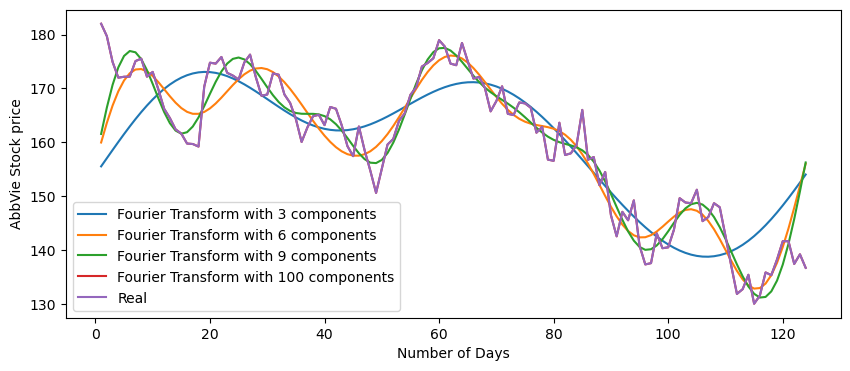

In [220]:
fft_list = np.asarray(fft_df['fft'].tolist())
for num in [3, 6, 9, 100]:
    fft_list_m10 = np.copy(fft_list); fft_list_m10[num:-num]=0
    plt.plot(range(1,len(aapl)+1),np.fft.ifft(fft_list_m10), label=f'Fourier Transform with {num} components')
plt.plot(range(1,len(aapl)+1), aapl.close, label='Real')
plt.xlabel('Number of Days')
plt.ylabel('AbbVie Stock price')
plt.legend()
plt.show()

In [221]:
aapl['fft'] = np.fft.fft(np.asarray(aapl['close'].tolist()))
aapl['absolute'] = aapl['fft'].apply(lambda x: np.abs(x))
aapl['angle'] = aapl['fft'].apply(lambda x: np.angle(x))
aapl = aapl.drop('fft',axis=1)
aapl.head()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,lag_0,lag_1,lag_2,lag_3,lag_4,next,out,absolute,angle
26172,177.830002,182.880005,177.710007,182.009995,180.434296,104487900,AAPL,2022-01-03,Consumer Electronics,Technology,182.009995,177.570007,178.199997,179.380005,179.289993,179.699997,Sell,19815.370056,0.000000
26173,182.630005,182.940002,179.119995,179.699997,178.144287,99310400,AAPL,2022-01-04,Consumer Electronics,Technology,179.699997,182.009995,177.570007,178.199997,179.380005,174.919998,Sell,784.219626,-2.116725
26174,179.610001,180.169998,174.639999,174.919998,173.405670,94537600,AAPL,2022-01-05,Consumer Electronics,Technology,174.919998,179.699997,182.009995,177.570007,178.199997,172.000000,Sell,574.440926,-1.196062
26175,172.699997,175.300003,171.639999,172.000000,170.510956,96904000,AAPL,2022-01-06,Consumer Electronics,Technology,172.000000,174.919998,179.699997,182.009995,177.570007,172.169998,Buy,155.247278,-2.613676
26176,172.889999,174.139999,171.029999,172.169998,170.679504,86709100,AAPL,2022-01-07,Consumer Electronics,Technology,172.169998,172.000000,174.919998,179.699997,182.009995,172.190002,Buy,238.517504,-0.702477


### Stochastic Oscillator Indicator
A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result. https://www.investopedia.com/terms/s/stochasticoscillator.asp#:~:text=A%20stochastic%20oscillator%20is%20a,moving%20average%20of%20the%20result.

In [222]:
def stok(df, n):
    aapl['stok'] = ((aapl['close'] - aapl['low'].rolling(window=n, center=False).mean()) /
                 (aapl['high'].rolling(window=n, center=False).max() - 
                  aapl['low'].rolling(window=n, center=False).min())) * 100
    aapl['stod'] = aapl['stok'].rolling(window=3, center=False).mean()
    return df

In [223]:
aapl_stock = stok(aapl, n=14)
aapl_stock.tail()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,...,lag_1,lag_2,lag_3,lag_4,next,out,absolute,angle,stok,stod
26291,139.899994,141.910004,139.770004,141.660004,140.819138,89116800,AAPL,2022-06-24,Consumer Electronics,Technology,...,138.270004,135.350006,135.869995,131.559998,141.660004,Buy,324.400589,1.434066,24.219885,6.583693
26292,142.699997,143.490005,140.970001,141.660004,140.819138,70207900,AAPL,2022-06-27,Consumer Electronics,Technology,...,141.660004,138.270004,135.350006,135.869995,137.440002,Sell,238.517504,0.702477,25.567527,18.708147
26293,142.130005,143.419998,137.320007,137.440002,136.624191,67083400,AAPL,2022-06-28,Consumer Electronics,Technology,...,141.660004,141.660004,138.270004,135.350006,139.229996,Buy,155.247278,2.613676,7.633224,19.140212
26294,137.460007,140.669998,136.669998,139.229996,138.403564,66242400,AAPL,2022-06-29,Consumer Electronics,Technology,...,137.440002,141.660004,141.660004,138.270004,136.720001,Sell,574.440926,1.196062,21.949805,18.383518
26295,137.250000,138.369995,133.770004,136.720001,135.908463,98964500,AAPL,2022-06-30,Consumer Electronics,Technology,...,139.229996,137.440002,141.660004,141.660004,138.929993,Buy,784.219626,2.116725,15.684611,15.089213


<AxesSubplot:xlabel='stod', ylabel='Count'>

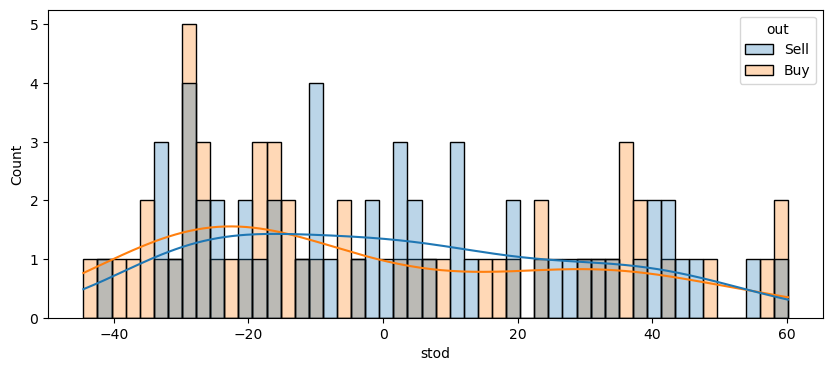

In [224]:
plt.rc('figure', figsize=(10, 4))
sns.histplot(x='stod',data=aapl_stock,hue='out',alpha=0.3,bins=50,kde=True)

<AxesSubplot:xlabel='stok', ylabel='Count'>

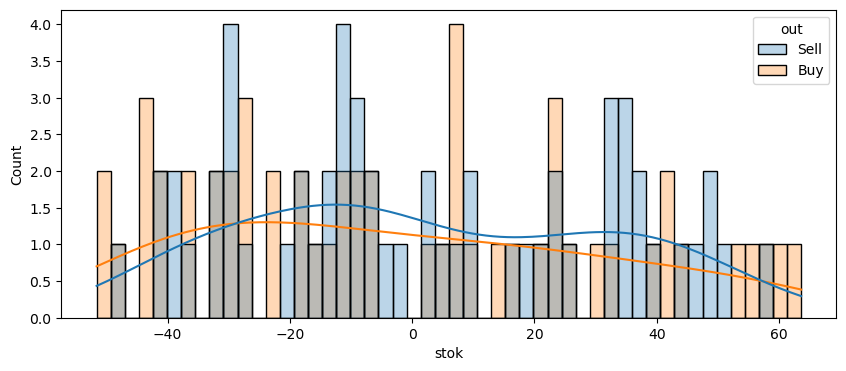

In [225]:
sns.histplot(x='stok',data=aapl_stock,hue='out',alpha=0.3,bins=50,kde=True)

### Commodity Channel Index (CCI)
momentum-based oscillator used to help determine when an investment vehicle is reaching a condition of being overbought or oversold. https://www.investopedia.com/terms/c/commoditychannelindex.asp

In [226]:
def CCI(df, ndays): 
    df['TP'] = (aapl['high'] + aapl['low'] + aapl['close']) / 3 
    df['sma'] = aapl['TP'].rolling(ndays).mean()
    df['mad'] = aapl['TP'].rolling(ndays).apply(lambda x: pd.Series(x).mad())
    df['CCI'] = (aapl['TP'] - df['sma']) / (0.015 * df['mad']) 
    return df

In [228]:
aapl_stock = CCI(aapl_stock, 20).drop(['TP','sma','mad'], axis=1)
#apl_stock.set_index('date', inplace=True)
aapl_stock.tail()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,...,lag_2,lag_3,lag_4,next,out,absolute,angle,stok,stod,CCI
26291,139.899994,141.910004,139.770004,141.660004,140.819138,89116800,AAPL,2022-06-24,Consumer Electronics,Technology,...,135.350006,135.869995,131.559998,141.660004,Buy,324.400589,1.434066,24.219885,6.583693,0.729439
26292,142.699997,143.490005,140.970001,141.660004,140.819138,70207900,AAPL,2022-06-27,Consumer Electronics,Technology,...,138.270004,135.350006,135.869995,137.440002,Sell,238.517504,0.702477,25.567527,18.708147,10.839959
26293,142.130005,143.419998,137.320007,137.440002,136.624191,67083400,AAPL,2022-06-28,Consumer Electronics,Technology,...,141.660004,138.270004,135.350006,139.229996,Buy,155.247278,2.613676,7.633224,19.140212,-14.266063
26294,137.460007,140.669998,136.669998,139.229996,138.403564,66242400,AAPL,2022-06-29,Consumer Electronics,Technology,...,141.660004,141.660004,138.270004,136.720001,Sell,574.440926,1.196062,21.949805,18.383518,-15.749210
26295,137.250000,138.369995,133.770004,136.720001,135.908463,98964500,AAPL,2022-06-30,Consumer Electronics,Technology,...,137.440002,141.660004,141.660004,138.929993,Buy,784.219626,2.116725,15.684611,15.089213,-42.710507


<AxesSubplot:xlabel='CCI', ylabel='Count'>

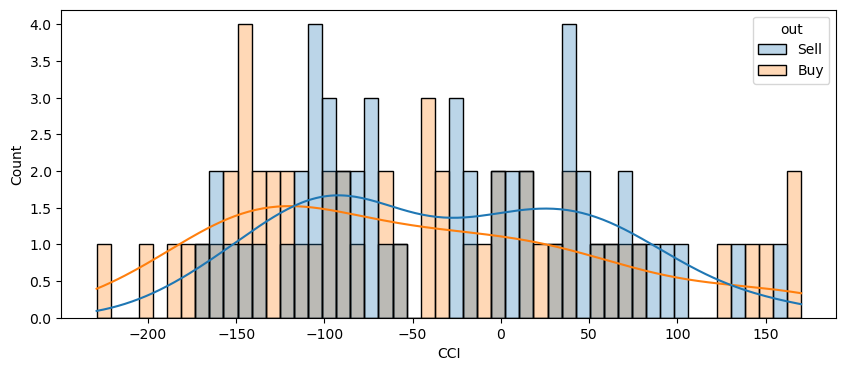

In [229]:
sns.histplot(x='CCI',data=aapl_stock,hue='out',alpha=0.3,bins=50,kde=True)

# Correlation Tickers in Sectors

array([[<AxesSubplot:title={'center':'Basic Materials'}>,
        <AxesSubplot:title={'center':'Communication Services'}>,
        <AxesSubplot:title={'center':'Consumer Cyclical'}>],
       [<AxesSubplot:title={'center':'Consumer Defensive'}>,
        <AxesSubplot:title={'center':'Energy'}>,
        <AxesSubplot:title={'center':'Financial Services'}>],
       [<AxesSubplot:title={'center':'Healthcare'}>,
        <AxesSubplot:title={'center':'Industrials'}>,
        <AxesSubplot:title={'center':'Real Estate'}>],
       [<AxesSubplot:title={'center':'Technology'}>,
        <AxesSubplot:title={'center':'Utilities'}>, <AxesSubplot:>]],
      dtype=object)

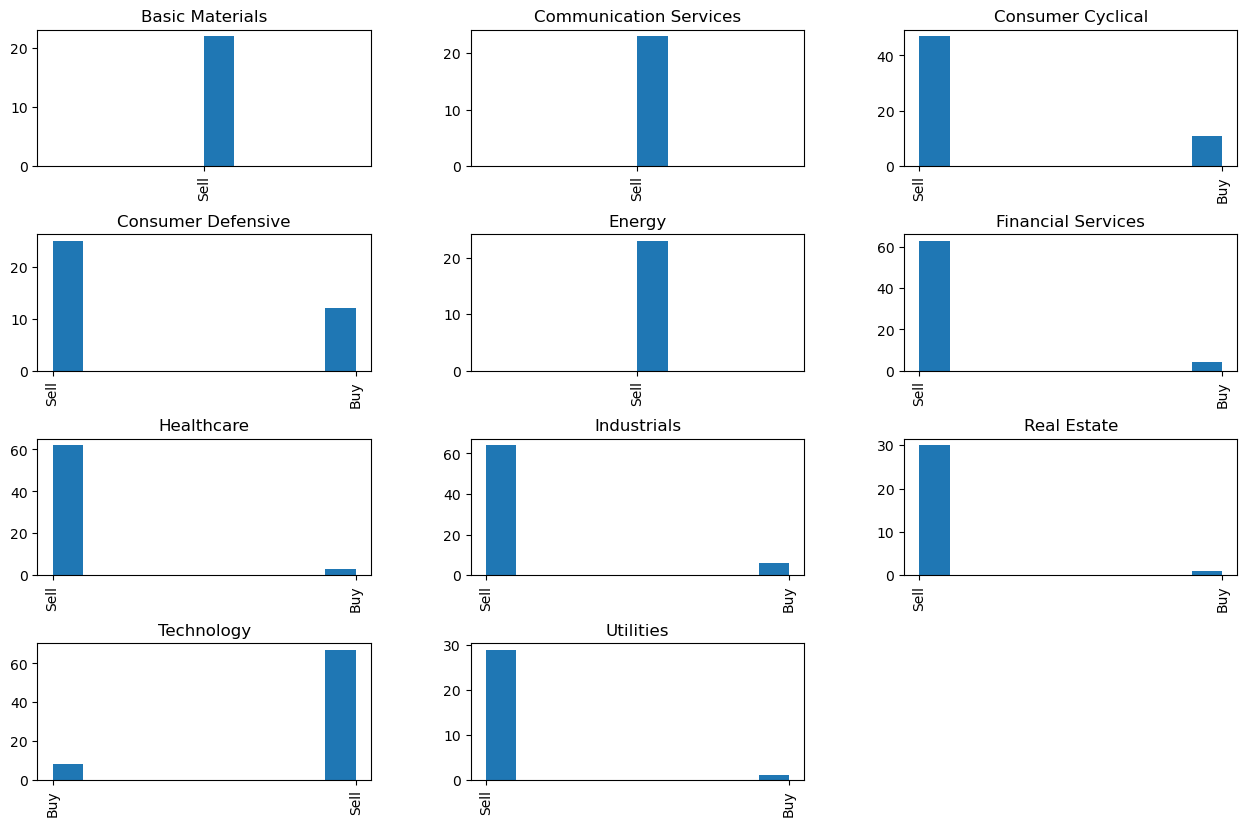

In [143]:
mask = (all['date'] == '2022-09-23') 
sector_ticker = all.loc[mask]
sector_ticker['out'].hist(by=sector_ticker['sector'])

### Correlation of ticker between sector

In [145]:
combined_info['sector'].unique()

array(['Healthcare', 'Industrials', 'Consumer Cyclical', 'Technology',
       'Financial Services', 'Consumer Defensive', 'Utilities',
       'Basic Materials', 'Real Estate', 'Energy',
       'Communication Services', nan], dtype=object)

Finantial Services

In [146]:
Consumer_Defensive = stock_day.loc[stock_day['sector'].isin(['Consumer Defensive'])]
sub_list = Consumer_Defensive.ticker.values.tolist()
print(sub_list)

['ADM', 'BF-B', 'BG', 'CAG', 'CHD', 'CL', 'CLX', 'COST', 'CPB', 'DG', 'DLTR', 'EL', 'GIS', 'HRL', 'HSY', 'K', 'KDP', 'KHC', 'KMB', 'KO', 'KR', 'LW', 'MDLZ', 'MKC', 'MNST', 'MO', 'NWL', 'PEP', 'PG', 'PM', 'SJM', 'STZ', 'SYY', 'TAP', 'TGT', 'TSN', 'WMT']


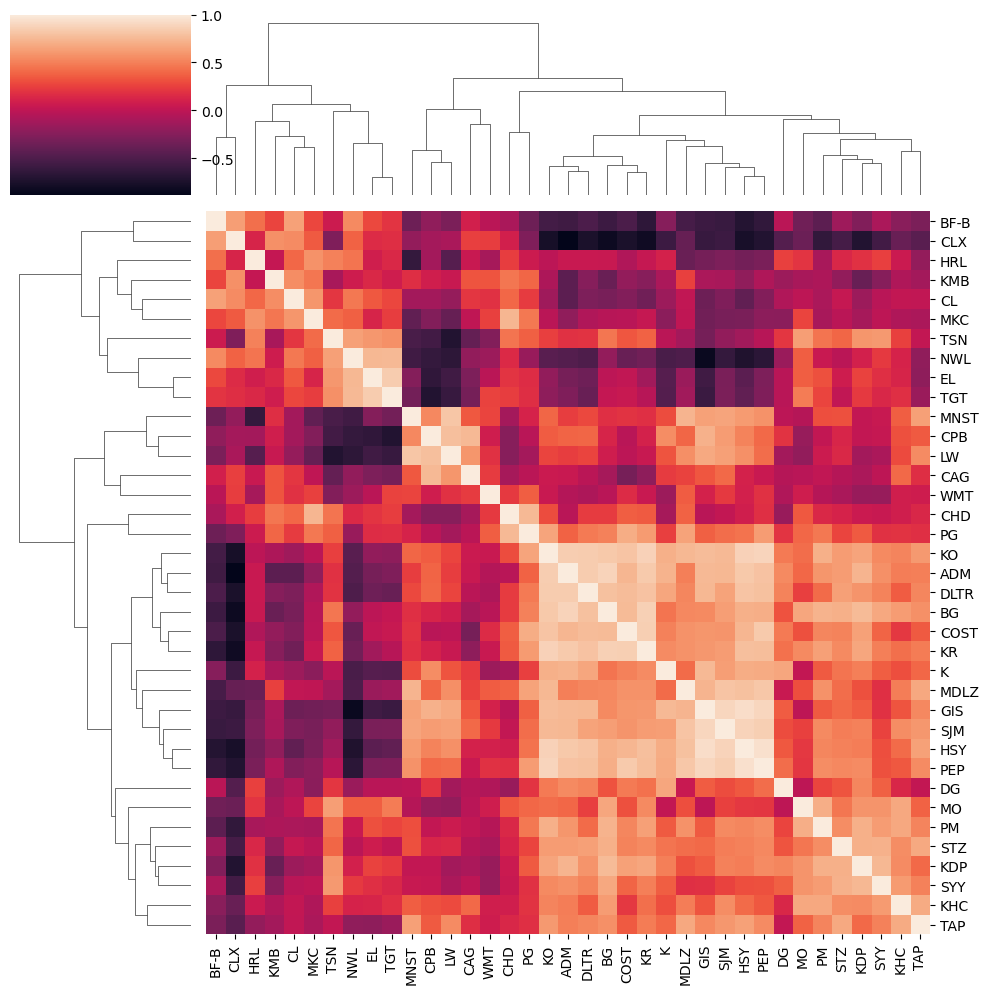

In [147]:
df_res = pd.DataFrame()
for ticker in sub_list:
    df_tmp = si.get_data(ticker,start_date='09-22-2020')
    df_res[ticker] = df_tmp['close']

corr = df_res.corr()
sns.clustermap(corr)
plt.tight_layout()

In [148]:
print(sub_list)

['ADM', 'BF-B', 'BG', 'CAG', 'CHD', 'CL', 'CLX', 'COST', 'CPB', 'DG', 'DLTR', 'EL', 'GIS', 'HRL', 'HSY', 'K', 'KDP', 'KHC', 'KMB', 'KO', 'KR', 'LW', 'MDLZ', 'MKC', 'MNST', 'MO', 'NWL', 'PEP', 'PG', 'PM', 'SJM', 'STZ', 'SYY', 'TAP', 'TGT', 'TSN', 'WMT']


In [153]:
test5 = all.loc[all['ticker'].isin(['MNST','NWL','EL','TGT','HRL','MKC','BF-B','CLX','CAG','CPB','LW','WMT','CL','KMB'])]
mask = (test5['date'] == '2022-09-23') 
test5 = test5.loc[mask]
test5.head()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,lag_0,lag_1,lag_2,lag_3,lag_4,next,out
522705,69.410004,69.529999,67.820000,68.559998,67.932602,954700,BF-B,2022-09-23,Beverages—Wineries & Distilleries,Consumer Defensive,68.559998,69.830002,70.800003,71.010002,71.230003,68.849998,Buy
659934,34.509998,34.790001,33.919998,34.349998,33.438828,2737400,CAG,2022-09-23,Packaged Foods,Consumer Defensive,34.349998,34.759998,34.320000,33.980000,34.240002,34.000000,Sell
794476,75.209999,75.930000,74.790001,75.529999,74.092766,4471900,CL,2022-09-23,Household & Personal Products,Consumer Defensive,75.529999,75.360001,74.900002,75.160004,76.010002,75.000000,Sell
807169,141.000000,142.470001,140.339996,141.580002,138.220459,933200,CLX,2022-09-23,Household & Personal Products,Consumer Defensive,141.580002,141.279999,141.970001,141.300003,142.929993,140.029999,Sell
932601,48.759998,49.220001,48.049999,48.599998,47.585930,2177200,CPB,2022-09-23,Packaged Foods,Consumer Defensive,48.599998,49.180000,48.529999,47.770000,48.049999,47.980000,Sell


<AxesSubplot:title={'center':'Consumer Defensive'}>

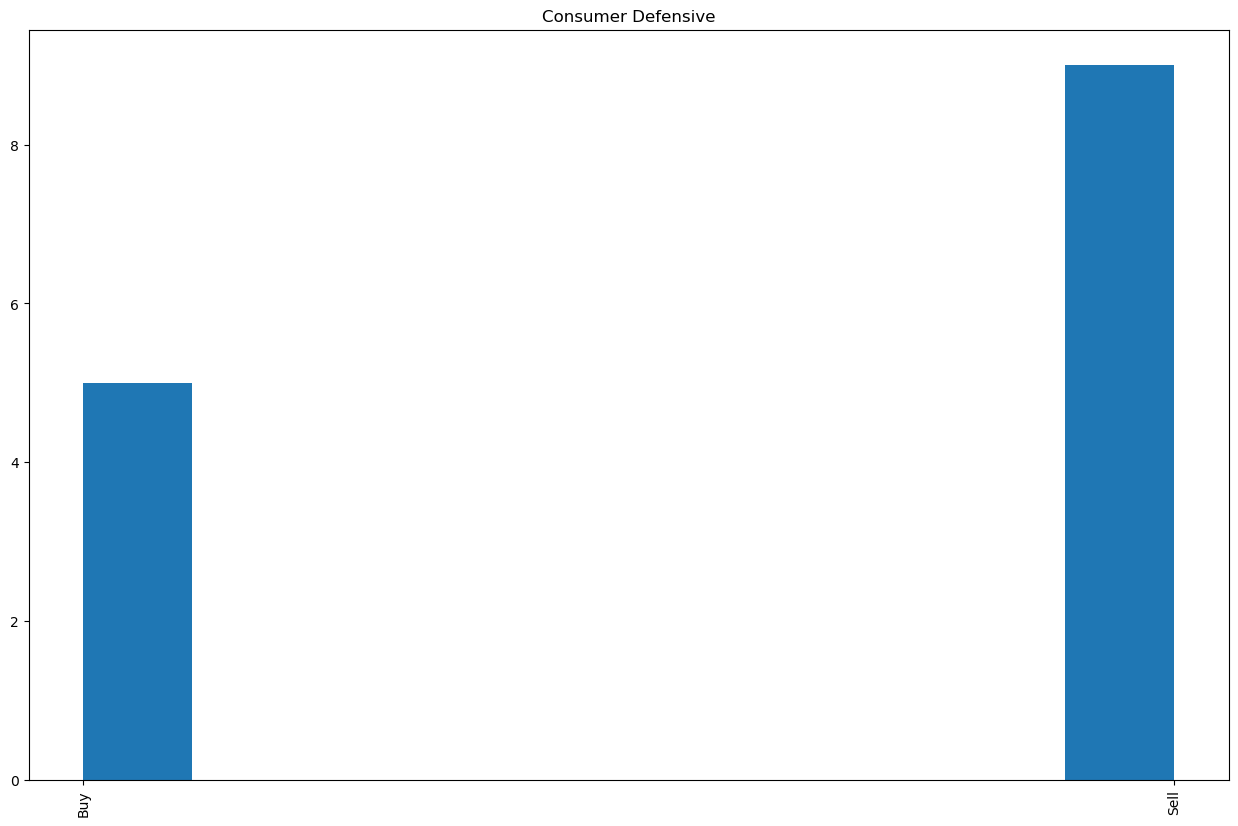

In [154]:
test5['out'].hist(by=test5['sector'])

In [155]:
test6 = all.loc[all['ticker'].isin(['CHD','PG','KHC','TAP','STZ','SYY','MD','PM','KDP','SJM','MDLZ','TSN','DS','K','DLTR','GIS','COST','PEP','KR','KO','ADM','HSY'])]
mask = (test6['date'] == '2022-09-23') 
test6 = test6.loc[mask]
test6.head()

,open,high,low,close,adjclose,volume,ticker,date,industry,sector,lag_0,lag_1,lag_2,lag_3,lag_4,next,out
90601,84.510002,84.510002,80.239998,81.650002,80.382576,3590200,ADM,2022-09-23,Farm Products,Consumer Defensive,81.650002,86.070000,86.000000,86.750000,87.330002,81.510002,Sell
750686,75.019997,75.620003,74.320000,75.220001,74.497353,1184800,CHD,2022-09-23,Household & Personal Products,Consumer Defensive,75.220001,75.199997,74.690002,75.080002,76.589996,75.260002,Buy
919908,478.940002,482.320007,463.529999,466.399994,463.783203,5377800,COST,2022-09-23,Discount Stores,Consumer Defensive,466.399994,487.170013,493.070007,499.519989,506.570007,480.299988,Buy
1138917,138.399994,142.020004,138.259995,141.289993,141.289993,2318500,DLTR,2022-09-23,Discount Stores,Consumer Defensive,141.289993,139.330002,141.869995,142.619995,142.910004,138.229996,Sell
1641668,80.089996,80.540001,78.300003,79.169998,77.641235,4795400,GIS,2022-09-23,Packaged Foods,Consumer Defensive,79.169998,80.779999,79.720001,75.410004,75.830002,78.660004,Sell


<AxesSubplot:title={'center':'Consumer Defensive'}>

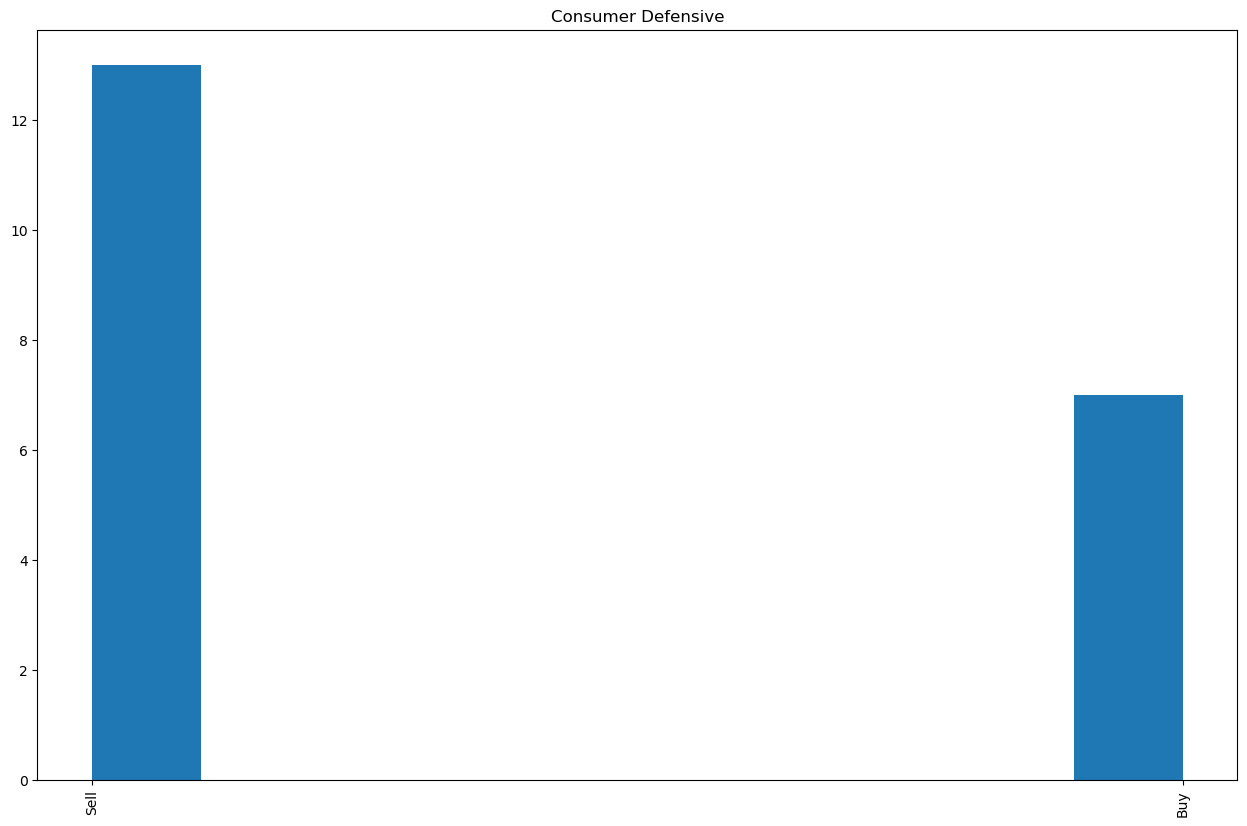

In [156]:
test6['out'].hist(by=test6['sector'])